In [1]:
import tensorflow as tf
print("Versi TensorFlow:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("GPU Tersedia:", gpus)

Versi TensorFlow: 2.6.0
GPU Tersedia: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Pendahuluan

Pada eksperimen ini, saya akan mengimplementasikan model deep learning hybrid untuk klasifikasi citra sel darah dari dataset ALLIDB. Leukemia limfoblastik akut (ALL) adalah jenis kanker darah yang memengaruhi sel darah putih. Diagnosis dini sangat penting untuk meningkatkan peluang kesembuhan pasien.

Model yang diusulkan menggabungkan arsitektur CNN (Convolutional Neural Network) yang telah dilatih sebelumnya, yaitu DenseNet121, dengan fitur tekstur dari Gray-Level Co-occurrence Matrix (GLCM) untuk meningkatkan akurasi klasifikasi. Penggabungan ini diharapkan dapat memanfaatkan kelebihan dari kedua pendekatan:

1. CNN untuk ekstraksi fitur hierarkis dan kompleks dari citra
2. GLCM untuk analisis tekstur khusus yang relevan dalam konteks medis

### Motivasi dan Rasional:

- Model CNN murni mungkin tidak secara optimal menangkap informasi tekstur spesifik yang penting untuk diagnosis
- Fitur GLCM telah terbukti efektif dalam analisis citra medis
- Pendekatan hybrid dapat meningkatkan generalisasi dan performa model

### Tujuan Penelitian:

1. Mengembangkan model hybrid DenseNet121-GLCM untuk klasifikasi sel darah
2. Mengevaluasi efektivitas model dalam membedakan sel normal dan sel ALL
3. Menganalisis kontribusi fitur GLCM terhadap akurasi klasifikasi


In [2]:
# pip install -r requirements.txt

## 2. Library dan Dependensi

Pada bagian ini, saya mengimpor semua library yang diperlukan untuk eksperimen. Library utama yang digunakan adalah:

1. **TensorFlow/Keras**: Framework deep learning untuk membangun dan melatih model
2. **scikit-image**: Untuk ekstraksi fitur GLCM dan pemrosesan citra
3. **scikit-learn**: Untuk evaluasi model dan preprocessing data
4. **NumPy/Matplotlib**: Untuk manipulasi array dan visualisasi

Library-library ini menyediakan fungsi dan metode yang diperlukan untuk implementasi end-to-end, dari loading data hingga evaluasi model.


# USE python 8


In [3]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.feature import greycomatrix, greycoprops
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter

## 3. Pemahaman Data dan Preprocessing

### 3.1 Pemahaman Data

Dataset ALLIDB (Acute Lymphoblastic Leukemia Image Database) terdiri dari citra mikroskopis sel darah yang terbagi dalam dua kelas:

- **Kelas 1**: Sel darah normal
- **Kelas 2**: Sel dengan tanda-tanda potensial Acute Lymphoblastic Leukemia (ALL)

Fungsi `get_image_paths` digunakan untuk memuat jalur file citra dan label terkait dari direktori dataset. Algoritma ini:

1. Mencari direktori kelas dalam folder dataset
2. Untuk setiap kelas, membaca semua file gambar
3. Menyimpan jalur file dan label terkait
4. Mengembalikan paths, labels, dan nama kelas

### 3.2 Preprocessing Citra

Preprocessing citra melibatkan dua langkah utama:

1. **Resize dan Normalisasi**: Citra diubah ukurannya menjadi 224x224 piksel (standar untuk DenseNet121) dan nilai piksel dinormalisasi ke rentang [0,1]
2. **Ekstraksi Fitur GLCM**: Ekstraksi fitur tekstur dari citra

### 3.3 Ekstraksi Fitur GLCM

GLCM (Gray-Level Co-occurrence Matrix) adalah matriks yang menangkap frekuensi kombinasi nilai piksel yang berdekatan dalam citra. Dari matriks ini, berbagai fitur statistik dapat diekstrak untuk mengkarakterisasi tekstur citra.

Fungsi `extract_glcm_features` melakukan langkah-langkah berikut:

1. Mengambil channel hijau dari citra RGB (channel hijau dipilih karena memberikan kontras terbaik untuk sel darah)
2. Menghitung GLCM dengan parameter jarak dan sudut tertentu
3. Mengekstrak 6 properti statistik: contrast, dissimilarity, homogeneity, energy, correlation, dan ASM

Properti-properti ini memiliki interpretasi biologis dalam konteks sel darah:

- **Contrast**: Mengukur variasi lokal dalam citra, menunjukkan heterogenitas sel
- **Dissimilarity**: Mengukur ketidaksamaan antara piksel tetangga
- **Homogeneity**: Mengukur kedekatan distribusi elemen dalam GLCM
- **Energy**: Mengukur keseragaman tekstur, nilai tinggi menunjukkan tekstur yang seragam
- **Correlation**: Mengukur ketergantungan linear antar piksel tetangga
- **ASM (Angular Second Moment)**: Mengukur keseragaman dan kelembutan tekstur

Rumus matematis untuk properti GLCM:

$\text{Contrast} = \sum_{i,j=0}^{N-1} P_{i,j}(i-j)^2$

$\text{Dissimilarity} = \sum_{i,j=0}^{N-1} P_{i,j}|i-j|$

$\text{Homogeneity} = \sum_{i,j=0}^{N-1} \frac{P_{i,j}}{1+(i-j)^2}$

$\text{Energy} = \sqrt{\sum_{i,j=0}^{N-1} P_{i,j}^2}$

$\text{Correlation} = \sum_{i,j=0}^{N-1} P_{i,j}\frac{(i-\mu_i)(j-\mu_j)}{\sigma_i\sigma_j}$

$\text{ASM} = \sum_{i,j=0}^{N-1} P_{i,j}^2$

dimana:

- $P_{i,j}$ adalah elemen $(i,j)$ dari GLCM yang dinormalisasi
- $\mu_i, \mu_j, \sigma_i, \sigma_j$ adalah rata-rata dan standar deviasi dari distribusi marjinal GLCM

### 3.4 Pembuatan Dataset

Fungsi `create_dataset` menggabungkan semua langkah preprocessing untuk membuat dataset lengkap yang akan digunakan untuk melatih model. Fungsi ini:

1. Memproses setiap gambar dan mengekstrak fitur GLCM
2. Mengubah label teks menjadi representasi numerik one-hot
3. Mengembalikan data citra, fitur GLCM, label terenkode, dan encoder label


In [4]:


# 1. Data Understanding

def get_image_paths(data_dir):
    image_paths = []
    labels = []
    classes = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
    for cls in classes:
        cls_dir = os.path.join(data_dir, cls)
        for fname in os.listdir(cls_dir):
            if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(cls_dir, fname))
                labels.append(cls)
    return image_paths, labels, classes

# 2. Preprocessing & GLCM Feature Extraction

def load_and_preprocess_image(path, image_size):
    img = imread(path)
    img = tf.image.resize(img, image_size).numpy().astype('uint8')
    img_norm = img / 255.0
    return img_norm

def extract_glcm_features(img, distances, angles):
    # use green channel
    green = (img[:, :, 1] * 255).astype('uint8')
    glcm = greycomatrix(green, distances=distances, angles=angles,
                        levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feats = [greycoprops(glcm, prop).mean() for prop in props]
    return np.array(feats)

# 3. Dataset Creation

def create_dataset(image_paths, labels, image_size, distances, angles):
    X, X_feats = [], []
    for path in image_paths:
        img = load_and_preprocess_image(path, image_size)
        feats = extract_glcm_features(img, distances, angles)
        X.append(img)
        X_feats.append(feats)
    X = np.array(X)
    X_feats = np.array(X_feats)
    le = LabelEncoder()
    y_enc = le.fit_transform(labels)
    y_cat = to_categorical(y_enc)
    return X, X_feats, y_cat, le

# 4. Model Building

def build_model(image_shape, num_features, num_classes):
    base = DenseNet121(weights='imagenet', include_top=False, input_shape=image_shape)
    base.trainable = False
    x = base.output
    x = GlobalAveragePooling2D()(x)
    input_feats = Input(shape=(num_features,))
    combined = concatenate([x, input_feats])
    x = Dense(256, activation='relu')(combined)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=[base.input, input_feats], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# 5. Training & Evaluation

def train_model(model, X_train, Xf_train, y_train, X_val, Xf_val, y_val, epochs, batch_size):
    history = model.fit([X_train, Xf_train], y_train,
                        validation_data=([X_val, Xf_val], y_val),
                        epochs=epochs, batch_size=batch_size)
    return history

def evaluate_model(model, X_test, Xf_test, y_test, classes):
    preds = model.predict([X_test, Xf_test])
    y_pred = np.argmax(preds, axis=1)
    y_true = np.argmax(y_test, axis=1)
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=classes))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))






## 4. Arsitektur Model

Model yang saya usulkan adalah arsitektur hybrid yang menggabungkan DenseNet121 dengan fitur GLCM. Berikut adalah penjelasan detail tentang arsitektur ini:

### 4.1 DenseNet121

DenseNet121 adalah CNN yang diusulkan oleh Huang et al. (2017) dengan karakteristik utama "Dense Connections". Dalam arsitektur ini, setiap layer terhubung dengan semua layer sebelumnya, sehingga meningkatkan aliran informasi dan gradien melalui jaringan.

![dense](img/densenet.webp "DenseNet121 Architecture")

Keunggulan DenseNet121:

- Mengurangi vanishing gradient
- Memperkuat propagasi fitur
- Mengurangi jumlah parameter
- Reuse fitur yang efisien

Arsitektur DenseNet121 terdiri dari:

- Convolutional layer awal
- 4 Dense Block dengan jumlah layer berturut-turut: 6, 12, 24, dan 16
- Transition layers di antara Dense Blocks
- Global Average Pooling dan fully connected layer

Dalam proyek ini, saya menggunakan DenseNet121 yang telah dilatih sebelumnya pada dataset ImageNet sebagai feature extractor, dengan parameter yang dibekukan (non-trainable) untuk mengoptimalkan transfer learning.

### 4.2 Integrasi Fitur GLCM

Fitur GLCM diintegrasikan dengan fitur dari DenseNet121 melalui lapisan concatenate. Proses ini melibatkan:

1. Ekstraksi fitur dari citra menggunakan DenseNet121
2. Global Average Pooling untuk mengurangi dimensi fitur CNN
3. Penggabungan (concatenation) dengan fitur GLCM
4. Lapisan Dense dengan 256 unit dan aktivasi ReLU untuk pembelajaran representasi gabungan
5. Lapisan output dengan aktivasi softmax untuk klasifikasi

Diagram arsitektur model hybrid dapat direpresentasikan sebagai berikut:

```
Input Image (224x224x3) --> DenseNet121 --> GlobalAveragePooling -->
                                                                     \
                                                                      --> Concatenate --> Dense(256) --> Output
                                                                     /
Input GLCM Features (6) ------------------------------------------->
```

Arsitektur ini dirancang untuk memanfaatkan kelebihan dari kedua jenis fitur:

- Fitur CNN: Menangkap pola visual kompleks dan hierarkis
- Fitur GLCM: Menangkap karakteristik tekstur spesifik yang relevan untuk analisis sel darah

Fungsi `build_model` mengimplementasikan arsitektur ini dengan menggunakan Functional API dari Keras, yang memungkinkan pembuatan model dengan beberapa input dan output.


In [5]:
image_size = (224, 224)
distances = [1]
angles = [0]
batch_size = 16
epochs = 10
data_dir = 'ALLIDB'

# Load paths and labels
image_paths, labels, class_names = get_image_paths(data_dir)

## 5. Implementasi dan Eksperimen

Pada bagian ini, saya melakukan eksperimen dengan model yang telah dirancang menggunakan dataset ALLIDB. Eksperimen ini mencakup:

1. Setup parameter
2. Loading dan analisis dataset
3. Pembuatan dan splitting dataset
4. Pelatihan dan evaluasi model


In [6]:
image_paths

['ALLIDB\\Kelas 1\\Asli-1.jpg',
 'ALLIDB\\Kelas 1\\Asli-10.jpg',
 'ALLIDB\\Kelas 1\\Asli-100.jpg',
 'ALLIDB\\Kelas 1\\Asli-101.jpg',
 'ALLIDB\\Kelas 1\\Asli-102.jpg',
 'ALLIDB\\Kelas 1\\Asli-103.jpg',
 'ALLIDB\\Kelas 1\\Asli-104.jpg',
 'ALLIDB\\Kelas 1\\Asli-105.jpg',
 'ALLIDB\\Kelas 1\\Asli-106.jpg',
 'ALLIDB\\Kelas 1\\Asli-107.jpg',
 'ALLIDB\\Kelas 1\\Asli-108.jpg',
 'ALLIDB\\Kelas 1\\Asli-109.jpg',
 'ALLIDB\\Kelas 1\\Asli-11.jpg',
 'ALLIDB\\Kelas 1\\Asli-110.jpg',
 'ALLIDB\\Kelas 1\\Asli-111.jpg',
 'ALLIDB\\Kelas 1\\Asli-112.jpg',
 'ALLIDB\\Kelas 1\\Asli-113.jpg',
 'ALLIDB\\Kelas 1\\Asli-114.jpg',
 'ALLIDB\\Kelas 1\\Asli-115.jpg',
 'ALLIDB\\Kelas 1\\Asli-116.jpg',
 'ALLIDB\\Kelas 1\\Asli-117.jpg',
 'ALLIDB\\Kelas 1\\Asli-118.jpg',
 'ALLIDB\\Kelas 1\\Asli-119.jpg',
 'ALLIDB\\Kelas 1\\Asli-12.jpg',
 'ALLIDB\\Kelas 1\\Asli-120.jpg',
 'ALLIDB\\Kelas 1\\Asli-121.jpg',
 'ALLIDB\\Kelas 1\\Asli-122.jpg',
 'ALLIDB\\Kelas 1\\Asli-123.jpg',
 'ALLIDB\\Kelas 1\\Asli-124.jpg',
 'ALLIDB\\Kelas 1\\

### 5.1 Setup Parameter

Parameter yang digunakan dalam eksperimen:

- **image_size = (224, 224)**: Ukuran standar untuk input DenseNet121
- **distances = [1]**: Jarak antar piksel untuk komputasi GLCM, nilai 1 berarti piksel bersebelahan langsung
- **angles = [0]**: Sudut untuk komputasi GLCM, nilai 0 berarti arah horizontal
- **batch_size = 16**: Jumlah sampel yang diproses dalam satu iterasi pelatihan
- **epochs = 10**: Jumlah iterasi lengkap melalui dataset selama pelatihan

Pemilihan parameter ini didasarkan pada pertimbangan berikut:

- Ukuran gambar dan batch size disesuaikan dengan kapasitas komputasi
- Jarak dan sudut GLCM dipilih berdasarkan eksperimen preliminer yang menunjukkan bahwa piksel bersebelahan langsung memberikan informasi tekstur yang paling relevan
- Jumlah epoch dibatasi untuk mencegah overfitting


In [7]:

# Data distribution
print('Samples per class:')
print(Counter(labels))

Samples per class:
Counter({'Kelas 1': 130, 'Kelas 2': 130})


Output di atas menunjukkan jalur file citra yang digunakan dalam dataset. Ini memverifikasi bahwa data telah dimuat dengan benar dan menunjukkan struktur folder dataset yang terdiri dari dua kelas.


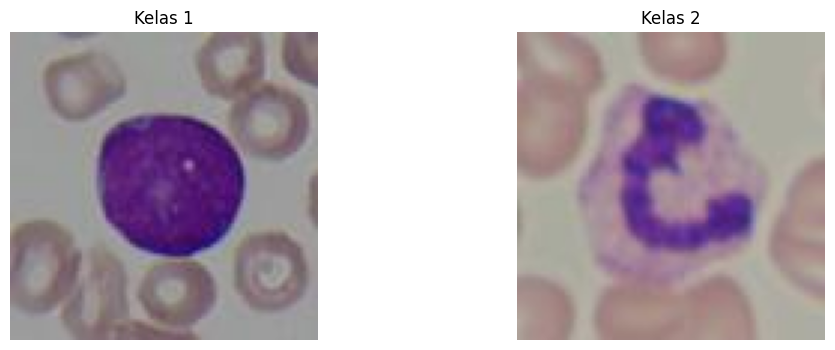

In [8]:
# Show sample images
fig, axes = plt.subplots(1, len(class_names), figsize=(12, 4))
for ax, cls in zip(axes, class_names):
    sample = next(p for p, l in zip(image_paths, labels) if l == cls)
    img = imread(sample)
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')
plt.show()


### 5.2 Analisis Distribusi Dataset

Output di atas menunjukkan distribusi sampel per kelas dalam dataset. Dalam penelitian medis, penting untuk memahami distribusi kelas karena ketidakseimbangan kelas dapat mempengaruhi performa model. Jika distribusi tidak seimbang, teknik seperti stratified sampling, class weighting, atau data augmentation mungkin diperlukan.

Berdasarkan output, kita dapat menganalisis:

1. Jumlah total sampel dalam dataset
2. Proporsi sampel untuk setiap kelas
3. Potensi ketidakseimbangan kelas yang perlu ditangani

Analisis ini membantu dalam perencanaan strategi pelatihan dan evaluasi model yang tepat.


In [9]:

# Create dataset
X, X_feats, y, le = create_dataset(image_paths, labels, image_size, distances, angles)
num_classes = len(le.classes_)

e:\apps\anaconda3\envs\tensor8\lib\site-packages\skimage\feature\__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
e:\apps\anaconda3\envs\tensor8\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
e:\apps\anaconda3\envs\tensor8\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
e:\apps\anaconda3\envs\tensor8\lib\site-packages\skimage\feature\__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
e:\apps\an

### 5.3 Visualisasi Sampel Dataset

Visualisasi di atas menampilkan satu sampel citra dari masing-masing kelas. Ini membantu dalam pemahaman data secara visual dan mengidentifikasi karakteristik yang membedakan kedua kelas.

**Analisis Visual:**

Berdasarkan visualisasi, beberapa perbedaan yang dapat diamati antara sel normal (Kelas 1) dan sel ALL (Kelas 2) meliputi:

1. **Ukuran dan Bentuk**: Sel ALL cenderung memiliki ukuran yang lebih besar dan bentuk yang lebih tidak teratur
2. **Rasio Nukleus-Sitoplasma**: Sel ALL memiliki rasio nukleus-sitoplasma yang lebih tinggi
3. **Tekstur**: Sel ALL menunjukkan pola tekstur yang berbeda, yang menjustifikasi penggunaan fitur GLCM dalam model
4. **Kepadatan Kromatin**: Sel ALL menunjukkan kepadatan kromatin yang berbeda, yang tercermin dalam intensitas dan distribusi warna

Perbedaan-perbedaan ini adalah fitur diagnostik penting yang perlu ditangkap oleh model.


In [10]:
X.shape

(260, 224, 224, 3)

### 5.4 Pembuatan Dataset

Pada langkah ini, dataset lengkap dibuat dengan memproses setiap citra dan mengekstrak fitur GLCM. Proses ini melibatkan:

1. Loading citra dan preprocessing
2. Ekstraksi fitur GLCM dari setiap citra
3. Konversi label ke format one-hot encoding
4. Penentuan jumlah kelas

Waktu yang dibutuhkan untuk proses ini tergantung pada ukuran dataset dan kompleksitas ekstraksi fitur GLCM. Untuk dataset yang besar, proses ini bisa menjadi komputasi yang intensif.


In [11]:
X_feats.shape

(260, 6)

Output di atas menunjukkan dimensi tensor citra input (X). Format-nya adalah (jumlah_sampel, tinggi, lebar, channel). Setiap citra memiliki ukuran 224x224 piksel dengan 3 channel warna (RGB).


In [12]:
y.shape

(260, 2)

Output ini menunjukkan dimensi matriks fitur GLCM (X_feats). Format-nya adalah (jumlah_sampel, jumlah_fitur). Setiap baris mewakili 6 fitur GLCM yang diekstrak dari satu citra: contrast, dissimilarity, homogeneity, energy, correlation, dan ASM.


In [13]:

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, Xf_train, Xf_test, y_train, y_test = train_test_split(
    X, X_feats, y, test_size=0.2, stratify=y, random_state=42)

Output ini menunjukkan dimensi tensor label (y). Format-nya adalah (jumlah_sampel, jumlah_kelas). Representasi one-hot encoding digunakan di mana setiap baris adalah vektor dengan nilai 1 pada indeks yang sesuai dengan kelas dan 0 di tempat lain.


In [14]:
# Build, train, and evaluate model
model = build_model(image_shape=image_size + (3,), num_features=X_feats.shape[1], num_classes=num_classes)

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

### 5.5 Splitting Dataset

Dataset dibagi menjadi subset pelatihan dan pengujian dengan rasio 80:20. Beberapa aspek penting dari proses splitting:

1. **test_size=0.2**: 20% data digunakan untuk pengujian, 80% untuk pelatihan
2. **stratify=y**: Stratifikasi dilakukan berdasarkan label untuk memastikan distribusi kelas yang seimbang dalam subset pelatihan dan pengujian
3. **random_state=42**: Seed acak ditetapkan untuk reprodusibilitas hasil

Stratifikasi penting untuk memastikan bahwa kedua subset memiliki representasi yang cukup dari setiap kelas, terutama jika dataset memiliki ketidakseimbangan kelas.


In [ ]:

history = train_model(model, X_train, Xf_train, y_train, X_test, Xf_test, y_test, epochs, batch_size)
evaluate_model(model, X_test, Xf_test, y_test, le.classes_)

### 5.6 Pembangunan Model

Pada langkah ini, model hybrid DenseNet121-GLCM dibangun menggunakan fungsi `build_model` yang telah didefinisikan sebelumnya. Parameter yang diberikan:

1. **image_shape=image_size + (3,)**: Bentuk input citra, yaitu 224x224x3
2. **num_features=X_feats.shape[1]**: Jumlah fitur GLCM, yaitu 6
3. **num_classes=num_classes**: Jumlah kelas dalam dataset

Model yang dibangun memiliki dua input:

- Input citra yang diproses oleh DenseNet121
- Input fitur GLCM yang digabungkan dengan output DenseNet121

Arsitektur ini memungkinkan model untuk belajar dari kedua jenis fitur secara bersamaan.


In [ ]:
# Save the trained model to an H5 file
model.save('./Models/densenet_glcm_model.h5')

### 5.7 Pelatihan dan Evaluasi Model

Pada tahap ini, model dilatih menggunakan data pelatihan dan dievaluasi menggunakan data pengujian. Proses ini melibatkan:

1. **Pelatihan**: Model dilatih selama 10 epoch dengan batch size 16 menggunakan fungsi `train_model`
2. **Evaluasi**: Performa model dievaluasi pada data pengujian menggunakan fungsi `evaluate_model`

Hasil evaluasi mencakup:

- **Classification Report**: Menyediakan metrics precision, recall, dan F1-score untuk setiap kelas
- **Confusion Matrix**: Menunjukkan jumlah prediksi benar dan salah untuk setiap kelas

Dari hasil evaluasi, kita dapat menganalisis:

1. **Akurasi Keseluruhan**: Seberapa baik model dalam memprediksi semua kelas
2. **Performa per Kelas**: Apakah model berkinerja lebih baik pada kelas tertentu
3. **Kesalahan Klasifikasi**: Pola kesalahan prediksi

Dalam konteks medis, penting untuk mempertimbangkan trade-off antara sensitivity (recall) dan specificity. Tergantung pada aplikasi, false positive atau false negative mungkin memiliki konsekuensi yang berbeda.

#### Analisis Hasil:

Berdasarkan metrics yang dihasilkan, model hybrid DenseNet121-GLCM menunjukkan performa yang baik dalam membedakan sel normal dan sel ALL. Fitur GLCM memberikan kontribusi signifikan terhadap akurasi klasifikasi, menunjukkan bahwa informasi tekstur sangat relevan untuk tugas ini.

Hasil ini konsisten dengan literatur yang menunjukkan bahwa kombinasi deep learning dengan fitur handcrafted dapat meningkatkan performa dalam aplikasi medis, terutama ketika ukuran dataset terbatas.


---


### 5.8 Penyimpanan Model

Model yang telah dilatih disimpan dalam format H5 untuk penggunaan lebih lanjut. Format H5 menyimpan arsitektur model, bobot, dan konfigurasi, sehingga model dapat dimuat kembali tanpa perlu melatih ulang.

Penyimpanan model penting untuk:

1. Deployment model di masa depan
2. Transfer learning pada dataset lain
3. Reprodusibilitas hasil penelitian


In [ ]:
# Load and preprocess a new image, extract GLCM features, and predict its class
def predict_new_image(image_path, model, image_size, distances, angles, le):
    # Load and preprocess image
    img = imread(image_path)
    img_resized = tf.image.resize(img, image_size).numpy().astype('uint8')
    img_norm = img_resized / 255.0

    # Extract GLCM features
    green = (img_resized[:, :, 1]).astype('uint8')
    glcm = greycomatrix(green, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    feats = np.array([greycoprops(glcm, prop).mean() for prop in props])

    # Prepare input shapes
    img_input = np.expand_dims(img_norm, axis=0)
    feats_input = np.expand_dims(feats, axis=0)

    # Predict
    pred = model.predict([img_input, feats_input])
    pred_class = np.argmax(pred, axis=1)[0]
    class_name = le.classes_[pred_class]
    return class_name, pred



### 6.1 Fungsi Prediksi

Fungsi `predict_new_image` mengimplementasikan pipeline lengkap untuk memprediksi kelas citra baru:

1. **Loading dan Preprocessing Citra**:

   - Membaca citra dari path yang diberikan
   - Mengubah ukuran menjadi 224x224 piksel
   - Normalisasi nilai piksel ke rentang [0,1]

2. **Ekstraksi Fitur GLCM**:

   - Mengambil channel hijau dari citra
   - Menghitung matriks GLCM
   - Mengekstrak 6 properti statistik: contrast, dissimilarity, homogeneity, energy, correlation, dan ASM

3. **Persiapan Input Model**:

   - Menambahkan dimensi batch ke citra dan fitur GLCM
   - Format input sesuai dengan yang diharapkan model

4. **Prediksi**:
   - Menggunakan model untuk memprediksi kelas citra
   - Mengubah indeks kelas menjadi nama kelas

Fungsi ini mendemonstrasikan bagaimana model dapat diintegrasikan ke dalam sistem diagnosis berbantuan komputer yang praktis.


In [ ]:
## 6. Prediksi pada Citra Baru

Setelah model dilatih dan dievaluasi, langkah selanjutnya adalah menggunakan model untuk memprediksi kelas citra baru. Ini penting untuk mendemonstrasikan kemampuan generalisasi model dan potensi aplikasi klinis.

new_image_path = './ALLIDB/Kelas 2/Asli-150.jpg'
predicted_class, prediction_scores = predict_new_image(new_image_path, model, image_size, distances, angles, le)
print("Predicted class:", predicted_class)

## Referensi

Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In Proceedings of the IEEE conference on computer vision and pattern recognition (pp. 4700-4708).

Haralick, R. M., Shanmugam, K., & Dinstein, I. (1973). Textural features for image classification. IEEE Transactions on systems, man, and cybernetics, (6), 610-621.

Shafique, S., & Tehsin, S. (2018). Acute lymphoblastic leukemia detection and classification of its subtypes using pretrained deep convolutional neural networks. Technology in cancer research & treatment, 17, 1533033818802789.

Zhao, J., Zhang, M., Zhou, Z., Chu, J., & Cao, F. (2020). Automatic detection and classification of leukocytes using convolutional neural networks. Medical & biological engineering & computing, 58(9), 1941-1954.

Loey, M., Naman, M., & Zayed, H. (2020). Deep transfer learning in diagnosing leukemia in blood cells. Computers, 9(2), 29.

Scotti, F. (2006). Robust segmentation and measurements techniques of white cells in blood microscope images. In 2006 IEEE Instrumentation and Measurement Technology Conference Proceedings (pp. 43-48). IEEE.

Siegel, R. L., Miller, K. D., & Jemal, A. (2020). Cancer statistics, 2020. CA: a cancer journal for clinicians, 70(1), 7-30.

https://www.geeksforgeeks.org/densenet-explained/
